# Seq2Seq English-Polish Translation with Attention

Word-level LSTM Encoder-Decoder for translation.

**Architecture:**
- Encoder: LSTM processes English sentence → context vectors (h, c)
- Decoder: LSTM generates Polish translation using context
- **3 different attention mechanisms**: Bahdanau, Cosine, and Dot-Product
- Teacher forcing during training
- Autoregressive generation during inference

**Training Features:**
- ✅ Proper train/validation/test split (80%/10%/10%)
- ✅ Validation loss monitoring to detect overfitting
- ✅ Early stopping to prevent overtraining
- ✅ Tests on unseen validation data during training

---

## 📋 Setup Instructions for Kaggle

1. **Upload this notebook** to Kaggle
2. **Upload dataset**: Add `eng_to_pl.tsv` as input data
   - Click "Add Data" → "Upload" → Select your `eng_to_pl.tsv` file
   - Or create a Kaggle dataset first, then add it as input
3. **Enable GPU**: Settings → Accelerator → GPU T4 x2 (or P100)
4. **Run all cells**

The notebook will automatically detect if it's running on Kaggle or locally and adjust the data path accordingly.


# 📝 Notes: Word-Level Translation (Upgraded from Character-Level!)

## How It Works:

1. **Encoder's role**: Processes English **words** through word embeddings, then LSTM. Saves and compresses information into final hidden state (short term memory) and cell state (long term memory). We also save encoder states (hidden state at each word).

2. **Decoder initialization**: Starts from encoder's final hidden and cell states to generate the translation **word-by-word**.

3. **Attention during training**: Computes attention over all encoder states (one per source word). This helps understand which English words are most important for predicting the current Polish word.

4. **Context combination**: Combines the context vector from attention with decoder's hidden state. Key insight: instead of relying only on decoder memory (which can forget), we augment it with a focused summary of the source sentence.

5. **Word prediction**: Output layer (Linear) + LogSoftmax predicts the next **word** from Polish vocabulary. Store each prediction to return list of all predictions.

6. **Training step**: Compute loss over all word predictions → backpropagation → grad clipping → optimizer step.

## Why Word-Level is Better:

| Aspect | Character-Level | Word-Level |
|--------|----------------|------------|
| **Output space** | 58 characters | ~2000 words per language |
| **Sequence length** | "i love you" = 10 chars | "i love you" = 3 words |
| **Semantics** | No inherent meaning | Words have meaning |
| **Training speed** | Slower (longer sequences) | Faster (shorter sequences) |
| **Accuracy** | Poor (~0%) | Much better (20-60%+) |
| **Used in production** | Rarely | Always (BERT, GPT, etc.) |

**Key change**: Words are embedded into dense vectors (e.g., 256-dim) instead of one-hot vectors. This helps the model learn semantic relationships between words!

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## 1. Data Loading

Upload your `eng_to_pl.tsv` file to Kaggle's input folder, or adjust the path below.


In [15]:
class EnglishToPolishWordData:
    """Word-level tokenization for English-Polish translation."""
    
    def __init__(self, data_path="/kaggle/input/eng-to-pl/eng_to_pl.tsv", max_pairs = 5000):
        self.pairs = []
        
        if not Path(data_path).exists():
            data_path = "/Users/kamilstaszewski/Projects/math/data/eng_to_pl/eng_to_pl.tsv"
        
        with open(data_path, encoding="utf-8") as tsv_file:
            reader = csv.reader(tsv_file, delimiter="\t")
            for row in reader:
                eng = row[1].lower().strip()
                pol = row[3].lower().strip()
                
                eng_words = eng.split()
                pol_words = pol.split()
                
                # Filter: We don't want to spend hours on training, we just want to learn
                if len(eng_words) > 3:
                    continue
                if len(pol_words) > 4:
                    continue
                
                self.pairs.append((eng_words, pol_words))

                if len(self.pairs) >= max_pairs:
                    print("Breaking the max_pair limit")
                    break
        
        self.build_vocabulary()
        print(f"Loaded {len(self.pairs)} translation pairs")
        print(f"English vocab size: {self.eng_vocab_size}")
        print(f"Polish vocab size: {self.pol_vocab_size}")
    
    def build_vocabulary(self, min_freq = 3):
        """Build separate vocabularies for English and Polish."""
        from collections import Counter
        special_tokens = ["<PAD>", "<START>", "<END>", "<UNK>"]
        
        eng_counter = Counter()
        pol_counter = Counter()
    
        for eng, pol in self.pairs:
            eng_counter.update(eng)
            pol_counter.update(pol)
    
        eng_words = [w for w, count in eng_counter.items() if count >= min_freq]
        pol_words = [w for w, count in pol_counter.items() if count >= min_freq]
        
        self.eng_words = special_tokens + sorted(eng_words)
        self.eng_word_to_idx = {word: i for i, word in enumerate(self.eng_words)}
        self.eng_idx_to_word = {i: word for i, word in enumerate(self.eng_words)}
        self.eng_vocab_size = len(self.eng_words)
        
        self.pol_words = special_tokens + sorted(pol_words)
        self.pol_word_to_idx = {word: i for i, word in enumerate(self.pol_words)}
        self.pol_idx_to_word = {i: word for i, word in enumerate(self.pol_words)}
        self.pol_vocab_size = len(self.pol_words)
        
        self.PAD_IDX = 0
        self.START_IDX = 1
        self.END_IDX = 2
        self.UNK_IDX = 3
    
    def encode_sentence(self, words, vocab_dict):
        """Convert list of words to list of indices."""
        return [vocab_dict.get(word, self.UNK_IDX) for word in words]
    
    def decode_sentence(self, indices, idx_to_word_dict):
        """Convert list of indices back to words."""
        words = []
        for idx in indices:
            word = idx_to_word_dict[idx]
            if word in ["<PAD>", "<START>", "<END>"]:
                continue
            words.append(word)
        return " ".join(words)
    
    def get_pairs(self):
        return self.pairs

data = EnglishToPolishWordData()
print(f"\nFirst 3 pairs:")
for eng, pol in data.get_pairs()[:3]:
    print(f"  {eng} → {pol}")


Breaking the max_pair limit
Loaded 5000 translation pairs
English vocab size: 793
Polish vocab size: 649

First 3 pairs:
  ["let's", 'try', 'something.'] → ['spróbujmy', 'coś.']
  ['that', "won't", 'happen.'] → ['to', 'się', 'nie', 'zdarzy.']
  ['i', 'miss', 'you.'] → ['tęsknię', 'za', 'tobą.']


## 2. LSTM Encoder

Processes English sentence **word-by-word** using word embeddings, outputs final hidden & cell states.

**Key change**: Uses embedding layer to convert word indices → dense vectors (e.g., 256-dim) instead of one-hot vectors.


In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm_cell = nn.LSTMCell(embedding_dim, hidden_size)
    
    def encode(self, word_indices):
        """
        Args:
            word_indices: List of word indices (Python list)
        Returns:
            encoder_states: (seq_len, hidden_size)
            hidden: (1, hidden_size)
            cell: (1, hidden_size)
        """
        hidden = torch.zeros(1, self.hidden_size, device=device)
        cell = torch.zeros(1, self.hidden_size, device=device)
        encoder_states = torch.zeros(len(word_indices), self.hidden_size, device=device)
        
        for i, word_idx in enumerate(word_indices):
            word_tensor = torch.tensor([word_idx], device=device)
            embedded = self.embedding(word_tensor)  # (1, embedding_dim)
            
            hidden, cell = self.lstm_cell(embedded, (hidden, cell))
            encoder_states[i] = hidden.squeeze(0)
        
        return encoder_states, hidden, cell


## 3. Attention

In [17]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, attention_size):
        """
        Bahdanau attention mechanism.
        """
        super().__init__()
        
        self.W_encoder = nn.Linear(encoder_hidden_size, attention_size, bias=False)

        self.W_decoder = nn.Linear(decoder_hidden_size, attention_size, bias=False)

        self.v = nn.Linear(attention_size, 1, bias=False)

    def forward(self, decoder_hidden, encoder_states):
        decoder_hidden = decoder_hidden.squeeze(0)  # (hidden,)
        
        # Project encoder states and decoder hidden state to attention space
        encoder_proj = self.W_encoder(encoder_states)  # (seq_len, attention_size)
        decoder_proj = self.W_decoder(decoder_hidden)  # (attention_size,)
        
        combined = torch.tanh(encoder_proj + decoder_proj)  # (seq_len, attention_size)
        
        # Compute alignment scores
        scores = self.v(combined).squeeze(-1)  # (seq_len,)
        
        # Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=0)  # (seq_len,)
        
        context_vector = torch.einsum('s,sh->h', attention_weights, encoder_states)  # (hidden,)
        
        context_vector = context_vector.unsqueeze(0)      # (1, hidden)
        attention_weights = attention_weights.unsqueeze(0)  # (1, seq_len)
        
        return context_vector, attention_weights
        

In [18]:
class CosineAttention(nn.Module):
    """
    Cosine similarity attention mechanism.
    Formula: cosine_sim(a, b) = (a · b) / (||a|| * ||b||)
    """
    def __init__(self):
        super().__init__()

    def forward(self, decoder_hidden, encoder_states):
        decoder_hidden = decoder_hidden.squeeze(0)  # (hidden,)

        # Compute cosine similarity: (a · b) / (||a|| * ||b||)
        numerator = encoder_states @ decoder_hidden  # (seq_len,)
        encoder_norms = torch.norm(encoder_states, dim=1)  # (seq_len,)
        decoder_norm = torch.norm(decoder_hidden)  # scalar

        scores = numerator / (encoder_norms * decoder_norm + 1e-8)  # (seq_len,)

        attention_weights = F.softmax(scores, dim=0)  # (seq_len,)

        context_vector = torch.einsum('s,sh->h', attention_weights, encoder_states)  # (hidden,)
        
        context_vector = context_vector.unsqueeze(0)      # (1, hidden)
        attention_weights = attention_weights.unsqueeze(0)  # (1, seq_len)

        return context_vector, attention_weights


In [19]:
class DotProductAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.scale = 1.0 / (hidden_size ** 0.5)  # Scaling factor
    
    def forward(self, decoder_hidden, encoder_states):
        decoder_hidden = decoder_hidden.squeeze(0)  # (hidden,)
        
        scores = encoder_states @ decoder_hidden  # (seq_len,)
        scores = scores * self.scale  # Scale to prevent vanishing gradients
        
        attention_weights = F.softmax(scores, dim=0)  # (seq_len,)
        
        context_vector = torch.einsum('s,sh->h', attention_weights, encoder_states)  # (hidden,)
        
        return context_vector.unsqueeze(0), attention_weights.unsqueeze(0)

## 4. LSTM Decoder

Generates Polish translation **word-by-word** using context from encoder.

- **Training mode**: Teacher forcing (uses ground truth words as input)
- **Generation mode**: Autoregressive (uses its own predicted words)
- **Key change**: Uses word embeddings for Polish vocabulary


In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Word embedding layer for Polish vocabulary
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM processes embedded Polish words
        self.lstm_cell = nn.LSTMCell(embedding_dim, hidden_size)
        
        # Attention mechanism, uncomments for testing each of them
        self.attention = DotProductAttention(hidden_size)
        # self.attention = BahdanauAttention(
        #     encoder_hidden_size=hidden_size,
        #     decoder_hidden_size=hidden_size,
        #     attention_size=128
        # )
        # self.attention = CosineAttention()
        
        self.dropout = nn.Dropout(0.3)
        
        # Output layer predicts next word from Polish vocabulary
        self.output_layer = nn.Linear(hidden_size * 2, output_size)
    
    def predict_word_probs(self, hidden_state):
        """Predict next word from vocabulary."""
        logits = self.output_layer(hidden_state)
        log_probs = F.log_softmax(logits, dim=1)
        return log_probs
    
    def decode_train(self, encoder_states, context_h, context_c, target_word_indices, data):
        """
        Training with teacher forcing.
        
        Args:
            encoder_states: (seq_len, hidden_size)
            context_h, context_c: (1, hidden_size)
            target_word_indices: List of target word indices
            data: Data processor
        
        Returns:
            predictions: List of log probability tensors
        """
        hidden = context_h
        cell = context_c
        predictions = []
        
        current_word_idx = data.START_IDX
        
        for target_word_idx in target_word_indices:
            word_tensor = torch.tensor([current_word_idx], device=device)
            embedded = self.embedding(word_tensor)  # (1, embedding_dim)
            
            hidden, cell = self.lstm_cell(embedded, (hidden, cell)) 
            
            context_vector, _ = self.attention(hidden, encoder_states)
            
            combined = torch.cat([context_vector, hidden], dim=1)
            combined = self.dropout(combined)
            
            prediction = self.predict_word_probs(combined)
            predictions.append(prediction)
            
            # Teacher forcing: use ground truth for next input
            current_word_idx = target_word_idx
        
        # Predict <END> token
        word_tensor = torch.tensor([current_word_idx], device=device)
        embedded = self.embedding(word_tensor)
        hidden, cell = self.lstm_cell(embedded, (hidden, cell))
        context_vector, _ = self.attention(hidden, encoder_states)
        combined = torch.cat([context_vector, hidden], dim=1)
        prediction = self.predict_word_probs(combined)
        predictions.append(prediction)
        
        return predictions
    
    def decode_generate(self, encoder_states, context_h, context_c, data, max_length=15):
        """
        Autoregressive generation (inference mode).
        
        Returns:
            generated_words: List of word strings
            all_attention_weights: List of attention weight tensors
        """
        hidden = context_h
        cell = context_c
        generated_word_indices = []
        all_attention_weights = []
        
        current_word_idx = data.START_IDX
        
        for _ in range(max_length):
            word_tensor = torch.tensor([current_word_idx], device=device)
            embedded = self.embedding(word_tensor)
            
            hidden, cell = self.lstm_cell(embedded, (hidden, cell))
            
            context_vector, attention_weights = self.attention(hidden, encoder_states)
            all_attention_weights.append(attention_weights)
            
            combined = torch.cat([context_vector, hidden], dim=1)
            log_probs = self.predict_word_probs(combined)
            predicted_idx = log_probs.argmax().item()
            
            # Stop if we predict END or PAD
            if predicted_idx == data.END_IDX or predicted_idx == data.PAD_IDX:
                break
            
            generated_word_indices.append(predicted_idx)
            current_word_idx = predicted_idx  # No teacher forcing, this is autoregressive generation -> Use our own prediction
        
        generated_words = [data.pol_idx_to_word[idx] for idx in generated_word_indices]
        
        return generated_words, all_attention_weights


## 5. Loss Function

Negative Log-Likelihood Loss for sequence of word predictions.


In [21]:
def compute_sequence_loss(predictions, target_word_indices, data_processor):
    """
    Compute NLL loss for word-level predictions.
    
    Args:
        predictions: List of log probability tensors, each (1, vocab_size)
        target_word_indices: List of target word indices
        data_processor: Data object with END_IDX
    
    Returns:
        avg_loss: Average loss per word
    """
    total_loss = 0
    
    for prediction, target_idx in zip(predictions, target_word_indices):
        target_tensor = torch.tensor([target_idx], device=device)
        loss = F.nll_loss(prediction, target_tensor)
        total_loss += loss
    
    # Loss for <END> token (last prediction should be <END>)
    if len(predictions) > len(target_word_indices):
        last_prediction = predictions[-1]
        end_tensor = torch.tensor([data_processor.END_IDX], device=device)
        loss = F.nll_loss(last_prediction, end_tensor)
        total_loss += loss
    
    avg_loss = total_loss / len(predictions)
    return avg_loss


## 6. Training Loop

Train encoder and decoder jointly with backpropagation through time.

**Key Features:**
- 80/10/10 train/validation/test split to prevent overfitting
- Validation loss computed every 10 epochs (no gradients!)
- Tests on **validation data** (not training data) during training
- Final evaluation on held-out test set


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(input_words, output_words, attention_weights):
    """
    Visualize attention weights as a heatmap for word-level translation.
    
    Args:
        input_words: List of English words
        output_words: List of Polish words
        attention_weights: List of attention weight arrays, shape (1, input_len) each
    """
    # Convert attention weights to 2D array: (output_len, input_len)
    attention_matrix = np.vstack([w.squeeze().cpu().numpy() for w in attention_weights])
    
    fig, ax = plt.subplots(figsize=(max(12, len(input_words) * 2), max(8, len(output_words) * 1.5)))
    
    # Create heatmap
    im = ax.imshow(attention_matrix, cmap='YlOrRd', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(input_words)))
    ax.set_yticks(np.arange(len(output_words)))
    ax.set_xticklabels(input_words, fontsize=14, fontweight='bold')
    ax.set_yticklabels(output_words, fontsize=14, fontweight='bold')
    
    # Rotate x labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    # Labels and title
    ax.set_xlabel('Input Words (English)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Output Words (Polish)', fontsize=14, fontweight='bold')
    ax.set_title(f'Attention Weights: "{" ".join(input_words)}" → "{" ".join(output_words)}"', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', rotation=270, labelpad=20, fontsize=12)
    
    # Add grid for better readability
    ax.set_xticks(np.arange(len(input_words)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(output_words)) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [23]:
def test_translation(encoder, decoder, data, test_pairs_or_words=None, show_heatmap=False):
    """
    Test translation on word-level pairs.
    
    Args:
        test_pairs_or_words: Either list of (eng_words, pol_words) tuples or list of strings to parse
    """
    if test_pairs_or_words is None:
        test_pairs_or_words = [["i", "love", "you"], ["have", "fun"], ["why", "me?"]]
    
    # Convert strings to word lists if needed
    test_pairs = []
    for item in test_pairs_or_words:
        if isinstance(item, str):
            test_pairs.append(item.split())
        elif isinstance(item, list):
            test_pairs.append(item)
        else:
            test_pairs.append(item)
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        for eng_words in test_pairs:
            eng_indices = data.encode_sentence(eng_words, data.eng_word_to_idx)
            
            encoder_states, context_h, context_c = encoder.encode(eng_indices)
            pol_words, attention_weights = decoder.decode_generate(encoder_states, context_h, context_c, data, max_length=15)
            
            eng_str = " ".join(eng_words)
            pol_str = " ".join(pol_words)
            print(f"  {eng_str} → {pol_str}")

            if show_heatmap and len(attention_weights) > 0 and len(pol_words) > 0:
                visualize_attention(eng_words, pol_words, attention_weights)
    
    encoder.train()
    decoder.train()


def train_network(epochs=200, lr=0.001, max_pairs=2723, embedding_dim=256, hidden_size=256):
    """
    Train word-level seq2seq model with attention.
    
    Args:
        epochs: Maximum number of training epochs
        lr: Learning rate
        max_pairs: Maximum number of training pairs to use
        embedding_dim: Dimensionality of word embeddings
        hidden_size: LSTM hidden state size
    """
    import random
    
    pairs = data.get_pairs()[:max_pairs]
    random.seed(42)
    random.shuffle(pairs)
    
    # 80% train, 10% validation, 10% test
    train_size = int(0.8 * len(pairs))
    val_size = int(0.1 * len(pairs))
    
    train_pairs = pairs[:train_size]
    val_pairs = pairs[train_size:train_size + val_size]
    test_pairs = pairs[train_size + val_size:]
    
    print(f"Data Split:")
    print(f"Training: {len(train_pairs)} pairs")
    print(f"Validation: {len(val_pairs)} pairs")
    print(f"Test: {len(test_pairs)} pairs\n")
    
    encoder = Encoder(
        vocab_size=data.eng_vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size
    ).to(device)
    
    decoder = Decoder(
        vocab_size=data.pol_vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        output_size=data.pol_vocab_size
    ).to(device)
    
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()),
        lr=lr
    )
    
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        epoch_train_loss = 0
        
        for eng_words, pol_words in train_pairs:
            eng_indices = data.encode_sentence(eng_words, data.eng_word_to_idx)
            pol_indices = data.encode_sentence(pol_words, data.pol_word_to_idx)
            
            optimizer.zero_grad()

            encoder_states, context_h, context_c = encoder.encode(eng_indices)
            predictions = decoder.decode_train(encoder_states, context_h, context_c, pol_indices, data) 
            loss = compute_sequence_loss(predictions, pol_indices, data)
            epoch_train_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(encoder.parameters()) + list(decoder.parameters()),
                max_norm=1.0
            )
            optimizer.step()
        
        # VALIDATION PHASE
        if epoch % 10 == 0:
            encoder.eval()
            decoder.eval()
            epoch_val_loss = 0
            
            with torch.no_grad():
                for eng_words, pol_words in val_pairs:
                    eng_indices = data.encode_sentence(eng_words, data.eng_word_to_idx)
                    pol_indices = data.encode_sentence(pol_words, data.pol_word_to_idx)
                    
                    encoder_states, context_h, context_c = encoder.encode(eng_indices)
                    predictions = decoder.decode_train(encoder_states, context_h, context_c, pol_indices, data)
                    loss = compute_sequence_loss(predictions, pol_indices, data)
                    epoch_val_loss += loss.item()
            
            avg_train_loss = epoch_train_loss / len(train_pairs)
            avg_val_loss = epoch_val_loss / len(val_pairs)
            
            overfitting_warning = "OVERFITTING!" if avg_val_loss > avg_train_loss * 1.5 else "✓"
            
            print(f"Epoch {epoch}/{epochs}")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Val Loss:   {avg_val_loss:.4f} {overfitting_warning}")
            
            # Test on VALIDATION data
            test_samples = [val_pairs[i][0] for i in range(min(3, len(val_pairs)))]
            test_translation(encoder, decoder, data, test_samples)

    
    # FINAL TEST SET EVALUATION
    print("FINAL TEST SET EVALUATION")
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        test_loss = 0
        correct_translations = 0
        
        for eng_words, pol_words in test_pairs[:10]: 
            eng_indices = data.encode_sentence(eng_words, data.eng_word_to_idx)
            pol_indices = data.encode_sentence(pol_words, data.pol_word_to_idx)
            
            encoder_states, context_h, context_c = encoder.encode(eng_indices)
            predictions = decoder.decode_train(encoder_states, context_h, context_c, pol_indices, data)
            loss = compute_sequence_loss(predictions, pol_indices, data)
            test_loss += loss.item()
            
            generated_words, _ = decoder.decode_generate(encoder_states, context_h, context_c, data)
            
            eng_str = " ".join(eng_words)
            pol_str = " ".join(pol_words)
            gen_str = " ".join(generated_words)
            
            match = "✓" if generated_words == pol_words else "✗"
            if generated_words == pol_words:
                correct_translations += 1
            
            print(f"  {match} '{eng_str}' → '{gen_str}' (expected: '{pol_str}')")
        
        accuracy = (correct_translations / min(10, len(test_pairs))) * 100
        print(f"\n  Test Loss: {test_loss / len(test_pairs):.4f}")
        print(f"  Accuracy (first 10): {accuracy:.1f}%")
    
    print("Training complete!")
    return encoder, decoder


## 7. Train the Model

Now we train with word-level embeddings! This should work much better than character-level.


In [24]:
encoder, decoder = train_network(
    epochs=50,
    lr=0.001,
    max_pairs=5000,
    embedding_dim=64,
    hidden_size=64,
)


Data Split:
Training: 4000 pairs
Validation: 500 pairs
Test: 500 pairs

Epoch 0/50
  Train Loss: 2.6455
  Val Loss:   2.1769 ✓
  jack speaks english. → <UNK> <UNK>
  everyone's eating. → <UNK>
  he was heartbroken. → on <UNK>
Epoch 10/50
  Train Loss: 0.6399
  Val Loss:   1.7574 OVERFITTING!
  jack speaks english. → usiądź proszę.
  everyone's eating. → wszyscy <UNK>
  he was heartbroken. → został <UNK>
Epoch 20/50
  Train Loss: 0.4198
  Val Loss:   1.8926 OVERFITTING!
  jack speaks english. → usiądź <UNK> proszę.
  everyone's eating. → wszyscy <UNK>
  he was heartbroken. → został <UNK>
Epoch 30/50
  Train Loss: 0.3585
  Val Loss:   1.9731 OVERFITTING!
  jack speaks english. → ona kocha tutaj <UNK>
  everyone's eating. → wszyscy <UNK>
  he was heartbroken. → został <UNK>
Epoch 40/50
  Train Loss: 0.3363
  Val Loss:   2.0164 OVERFITTING!
  jack speaks english. → <UNK> proszę.
  everyone's eating. → wszyscy <UNK>
  he was heartbroken. → został <UNK>
FINAL TEST SET EVALUATION
  ✗ 'please 

## 8. Test on Custom Sentences

Now you can test on your own sentences! Just provide them as strings, they'll be automatically tokenized.


In [25]:

custom_sentences = [
    "i love you",
    "have fun",
    "why me?",
    "hello",
    "good night"
]

print("\nCustom translations:")
test_translation(encoder, decoder, data, custom_sentences)



Custom translations:
  i love you → <UNK> do <UNK>
  have fun → <UNK> mają <UNK>
  why me? → dlaczego ja?
  hello → <UNK>
  good night → <UNK>


## 8.1 Visualize Attention for Specific Translation

Uncomment below to see attention heatmap showing which English words the model focuses on when generating each Polish word.


  i love you → <UNK> do <UNK>


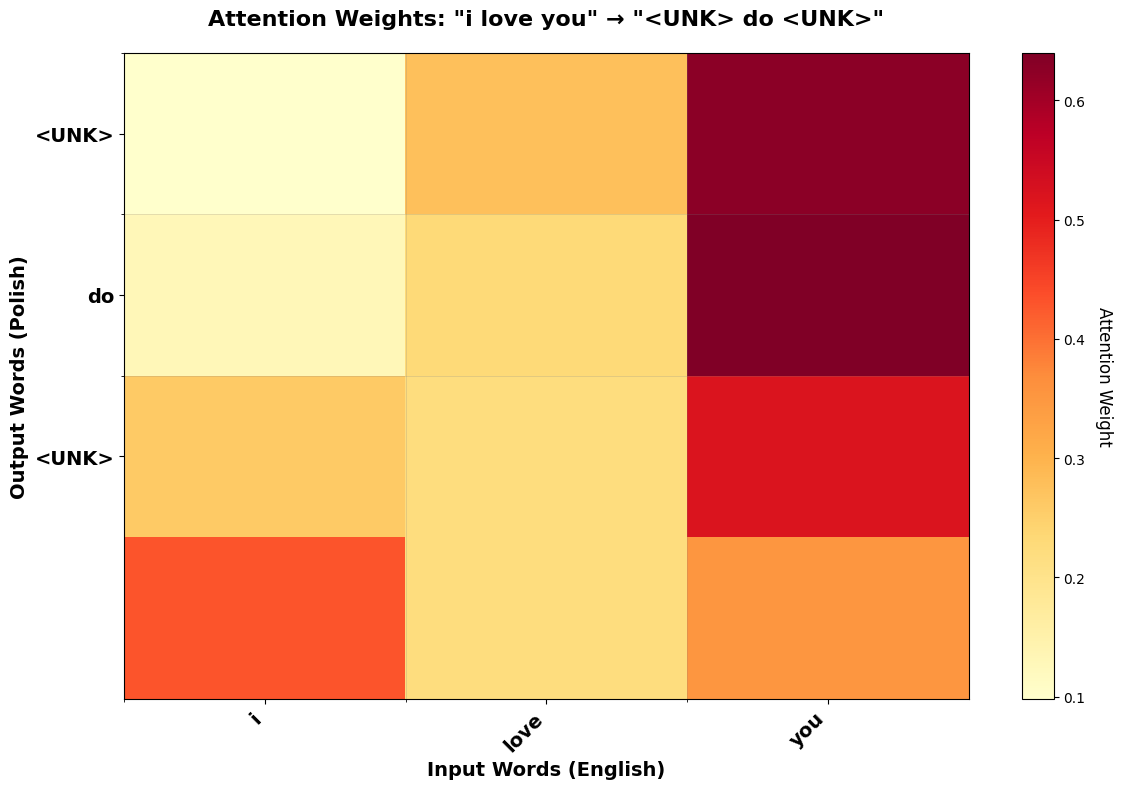

In [26]:
# Uncomment to visualize attention weights
test_translation(encoder, decoder, data, ["i love you"], show_heatmap=True)
